In [1]:
import pandas as pd
import numpy as np
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


## Part 1: EDA

### 1.a: Get Dataset & Descriptions


    train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
        PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
        HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
        CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
        Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
        Destination - The planet the passenger will be debarking to.
        Age - The age of the passenger.
        VIP - Whether the passenger has paid for special VIP service during the voyage.
        RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
        Name - The first and last names of the passenger.
        Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
  


In [2]:
train_df = pd.read_csv("train.csv")
print(f"Train dataset shape: {train_df.shape}")

Train dataset shape: (8693, 14)


### 1.b: Explanatory Data Analysis:

In [21]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [3]:
# Feature dtype masks:

obj_cols = train_df.select_dtypes("object").columns
num_cols = train_df.select_dtypes("number").columns

In [4]:
# Missing Data:
train_df.isna().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

In [5]:
# 1- Categorical Feats:

# It is seen that PassengerID & Name are unique ID's for the passengers, so will not be anaylsed. However, passenger_id can be used to analyse passenger groups& number of people in each group, so it will be analysed later

for col in ["HomePlanet","CryoSleep","Destination","VIP"]:
    print(f"{col}: \n{train_df[col].value_counts()}\n")

HomePlanet: 
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

CryoSleep: 
False    5439
True     3037
Name: CryoSleep, dtype: int64

Destination: 
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

VIP: 
False    8291
True      199
Name: VIP, dtype: int64



In [25]:
# Passenger Groups:
print(f"Total number of groups: {train_df.PassengerId.str[:4].nunique()}")
print(f"\nNumber of passengers in group counts: \n{train_df.PassengerId.str[:4].value_counts().value_counts()}")


Total number of groups: 6217

Number of passengers in group counts: 
1    4805
2     841
3     340
4     103
5      53
7      33
6      29
8      13
Name: PassengerId, dtype: int64


In [26]:
# Cabin: (deck/num/side)
# Deck:
print(f"Deck counts: \n{train_df.Cabin.str[0].value_counts()}")
#Side:
print(f"\nSide counts: \n{train_df.Cabin.str[-1].value_counts()}")

# If need to map Cabin nums:
# train_df.Cabin[train_df.Cabin.notna()].map(lambda x: re.search("\/(\w+)\/",x)[1])

Deck counts: 
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin, dtype: int64

Side counts: 
S    4288
P    4206
Name: Cabin, dtype: int64


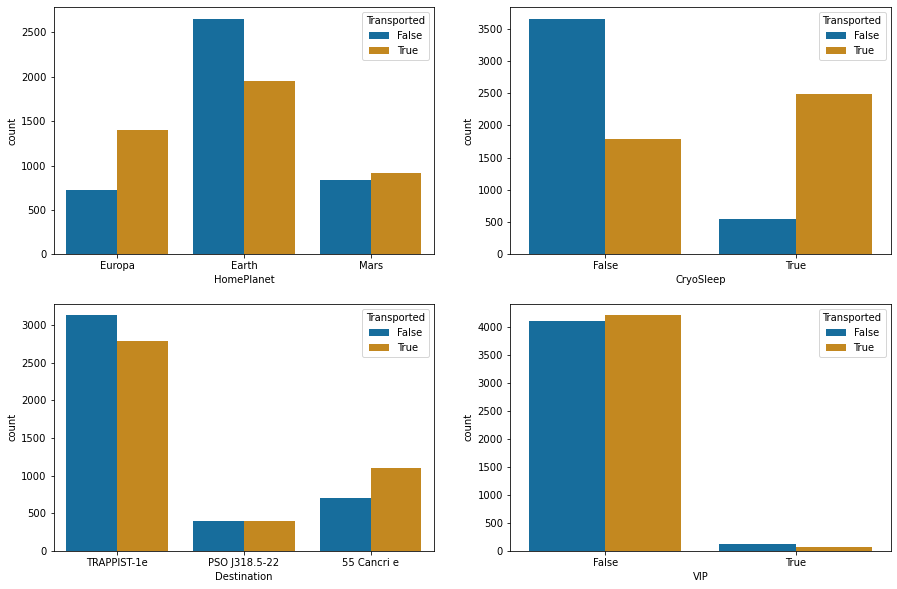

In [7]:
fig, ax =plt.subplots(2,2, figsize = (15, 10))

sns.set_palette("colorblind")

for num,col in enumerate(['HomePlanet', 'CryoSleep', 'Destination', 'VIP']): 
    sns.countplot(data=train_df, x=col, hue="Transported", ax=ax[int(num/2),int(num%2)])



Notes for categ variables:

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

* PassengerId -> can be used to get group info
* HomePlanet -> get_dummies()
* CryoSleep -> Boolean, get_dummies()
* Cabin -> can be used to get Deck & Side info
* Destination -> get_dummies()
* VIP -> Boolean, get_dummies()
* Name -> can be dropped

CryoSleep seems like a useful feature to be used during classification.


In [137]:
# 2- Numerical Features:

train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


At a first glance, the data seems "reasonable", as we can only make comments about the age variable intuiitively. As we don't know the currency, the rest of the variables can be accepted as they are.

Also, it is seen that as all the Money related columns have median = 0 and are heavvily skewed. This suggests that the NaN values should be filled with the median rather than the mean values.

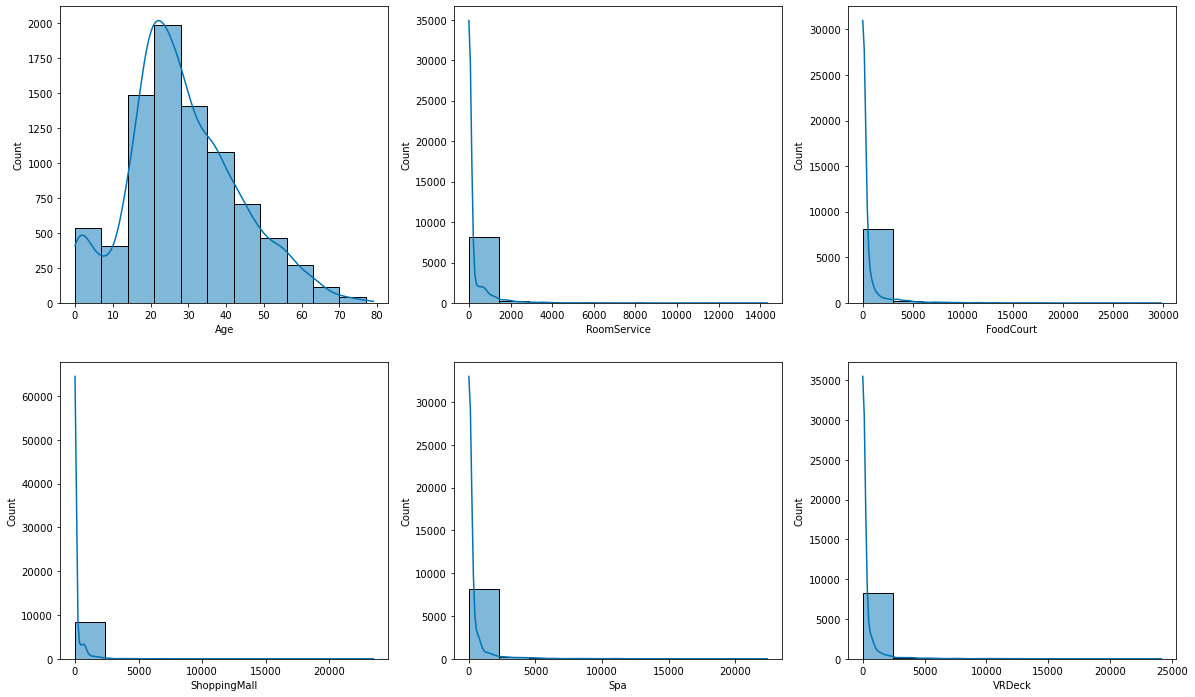

In [29]:
fig, ax =plt.subplots(2,3, figsize = (20, 12))

sns.set_palette("colorblind")

for num,col in enumerate(num_cols): 
    sns.histplot(data=train_df, x=col, kde=True, ax=ax[int(num/3),int(num%3)], bins=list(range(int(train_df[col].min()),int(train_df[col].max()),int(train_df[col].max()/10))))    

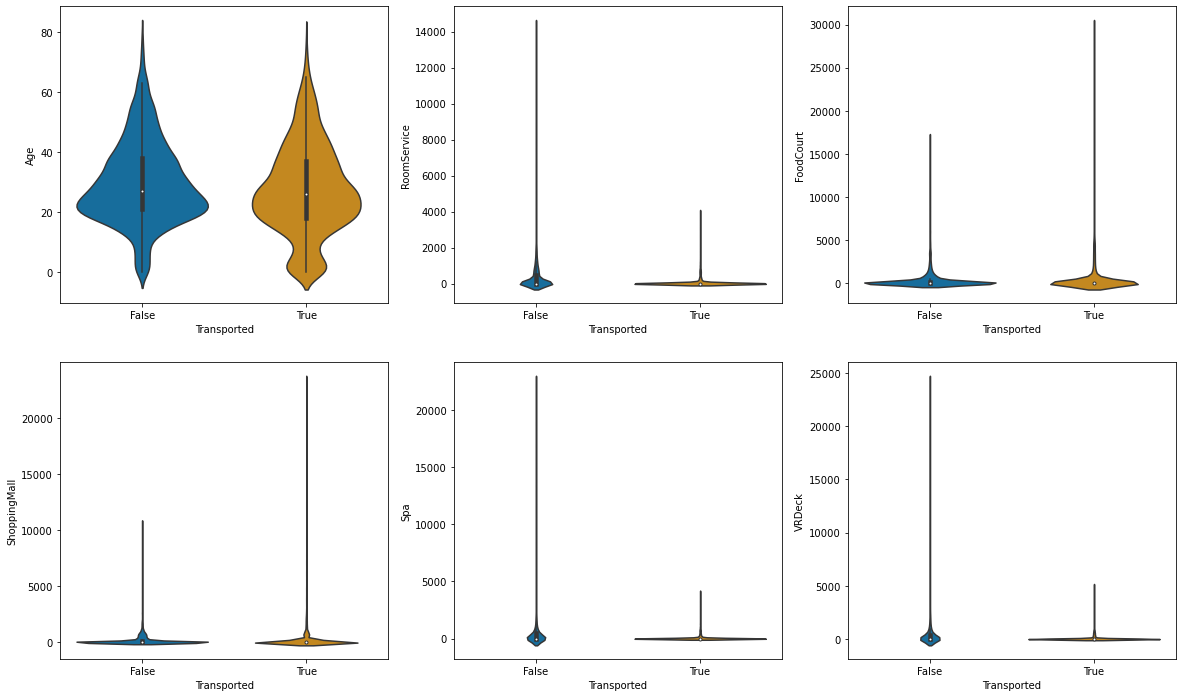

In [30]:
fig, ax =plt.subplots(2,3, figsize = (20, 12))

sns.set_palette("colorblind")

for num,col in enumerate(num_cols): 
    sns.violinplot(data=train_df, y=col, x="Transported", ax=ax[int(num/3),int(num%3)])

During analysis it is seen that the passengers in CyroSleep, were not able to spend any money, therefore skewing the graphs. 

Same graphs will be drawn without them to see if this makes any meaningful difference. 


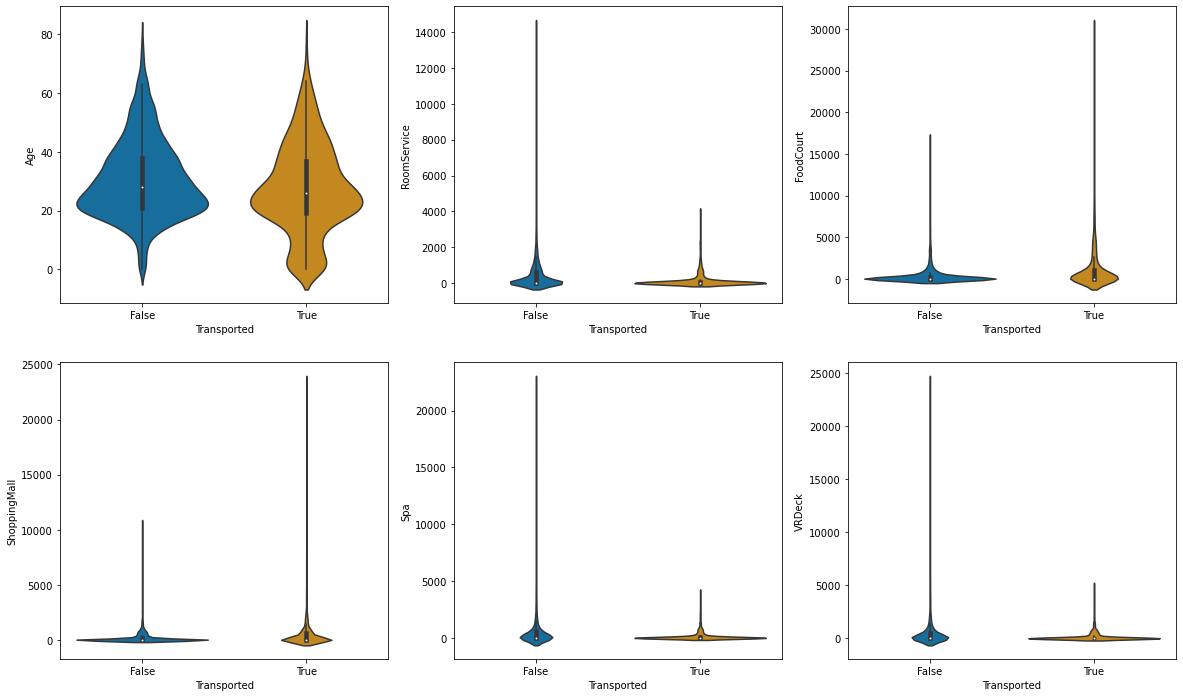

In [31]:
fig, ax = plt.subplots(2,3, figsize = (20, 12))

sns.set_palette("colorblind")

for num,col in enumerate(num_cols): 
    sns.violinplot(data=train_df[train_df.CryoSleep == False], y=col, x="Transported", ax=ax[int(num/3),int(num%3)])

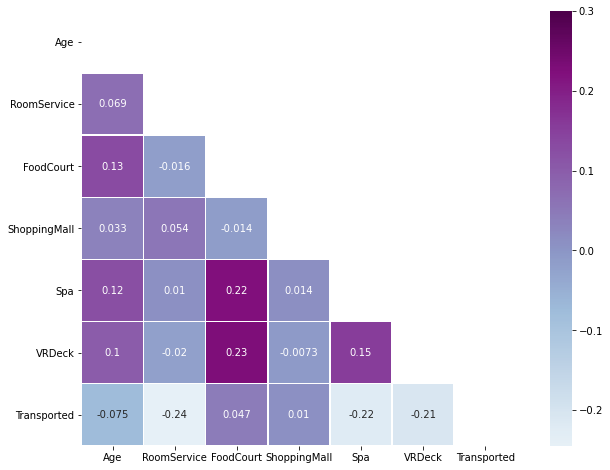

In [32]:
# Checking correlation heatmap:

plt.figure(figsize=(12,8))
corr=train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

Heatmap for CryoSleep == False:

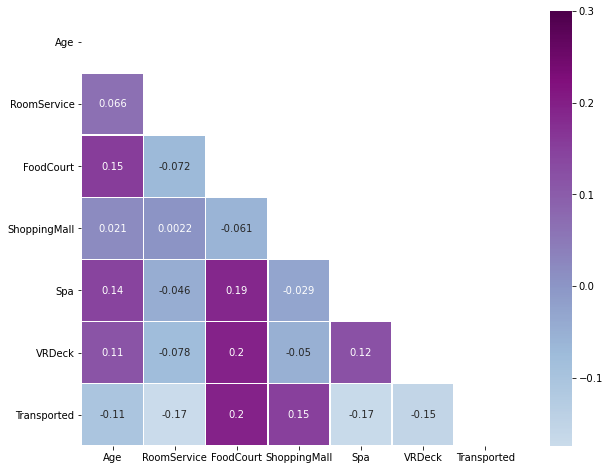

In [6]:
plt.figure(figsize=(12,8))
corr_no_cryo=train_df[train_df.CryoSleep == False].corr()
mask = np.triu(np.ones_like(corr_no_cryo, dtype=bool))
sns.heatmap(corr_no_cryo, mask=mask, cmap='BuPu', vmax=.3, center=0,
            square=True, linewidths=.5,annot=True)
plt.show()

Notes for numerical variables:

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

* Money related cols can be .fillna() using CyroSleep info & vice versa
* A TotalSpent col can be created by summing all Money cols
* None of the num. variables have high correlation with the target Transported.
* However, for "awake" (non-cryo-sleep) passengers, money related columns have a weak correlation with the target variable.


## Part 2: Dealing with Missing Values & Feature Engineering

### 2.1- Drop Columns

In [4]:
train_df.drop(["Name"], axis=1, inplace=True)

obj_cols = train_df.select_dtypes("object").columns
num_cols = train_df.select_dtypes("number").columns


### 2.2- Missing Values

In [5]:
# CyroSleep & Money Spending

train_df[train_df.CryoSleep == True][["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].fillna(0,inplace=True)
train_df.loc[(train_df["RoomService"]==0) & (train_df["FoodCourt"]==0) & (train_df["ShoppingMall"]==0) & (train_df["Spa"]==0) & (train_df["VRDeck"]==0),"CryoSleep"].fillna(True,inplace=True)

In [6]:
# Numerical Median fillna:
train_df.loc[:,num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# Cabin Case: (as it will be feat. eng. later, will fill with each indiv most freq of deck & side feats:)
train_df.loc[:,"Cabin"] = train_df["Cabin"].fillna("F/001/S")

# Categorical fillna:
simp = SimpleImputer(strategy="most_frequent")
train_df.loc[:,:"VRDeck"] = simp.fit_transform(train_df.drop("Transported", axis=1))

### 2.3- Feature Engineering

In [7]:
# 1 - Passenger Group Person count:
pssngr_group_count_dict = train_df.PassengerId.str[:4].value_counts().to_dict()
train_df["Pass_Group_Count"] = train_df.PassengerId.str[:4].map(pssngr_group_count_dict)


<AxesSubplot:xlabel='Pass_Group_Count', ylabel='count'>

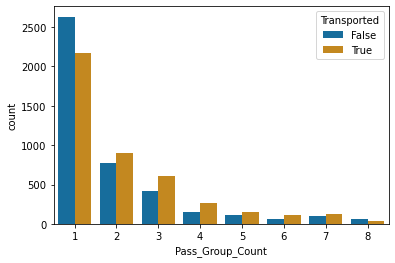

In [38]:
sns.countplot(data=train_df, x="Pass_Group_Count", hue= "Transported")

In [8]:
# 2 -  Cabin Deck
train_df["Cabin_deck"] = train_df.Cabin.str[0] 

# 3 - Cabin Side
train_df["Cabin_side"] = train_df.Cabin.str[-1]

<AxesSubplot:xlabel='Cabin_deck', ylabel='count'>

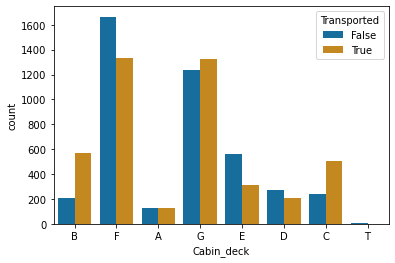

In [40]:
sns.countplot(data=train_df, x="Cabin_deck", hue= "Transported")

<AxesSubplot:xlabel='Cabin_side', ylabel='count'>

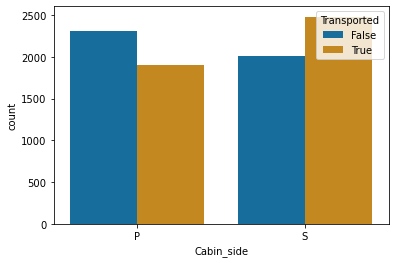

In [41]:
sns.countplot(data=train_df, x="Cabin_side", hue= "Transported")

In [9]:
# 4 - Total Money Spent:
train_df["Total_spent"] = train_df["RoomService"] + train_df["FoodCourt"] + train_df["ShoppingMall"] + train_df["Spa"] + train_df["VRDeck"]

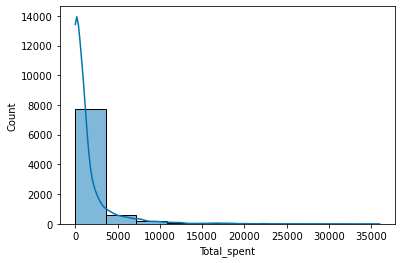

In [47]:
sns.histplot(data=train_df, x="Total_spent", bins =10, kde=True)
plt.show()

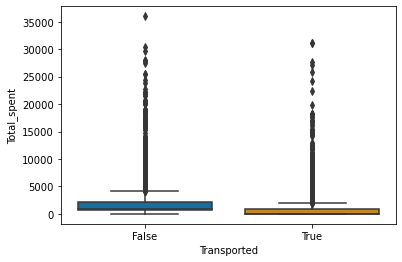

In [46]:
sns.boxplot(data=train_df, y="Total_spent", x="Transported")
plt.show()

In [48]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Pass_Group_Count,Cabin_deck,Cabin_side,Total_spent
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,P,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,F,S,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2,A,S,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,A,S,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,F,S,1091.0


In [10]:
# Cabin & PassengerId cols can now be dropped:

train_df.drop(["PassengerId","Cabin"], axis=1, inplace=True)

Checking the resulting feature space pairplot:

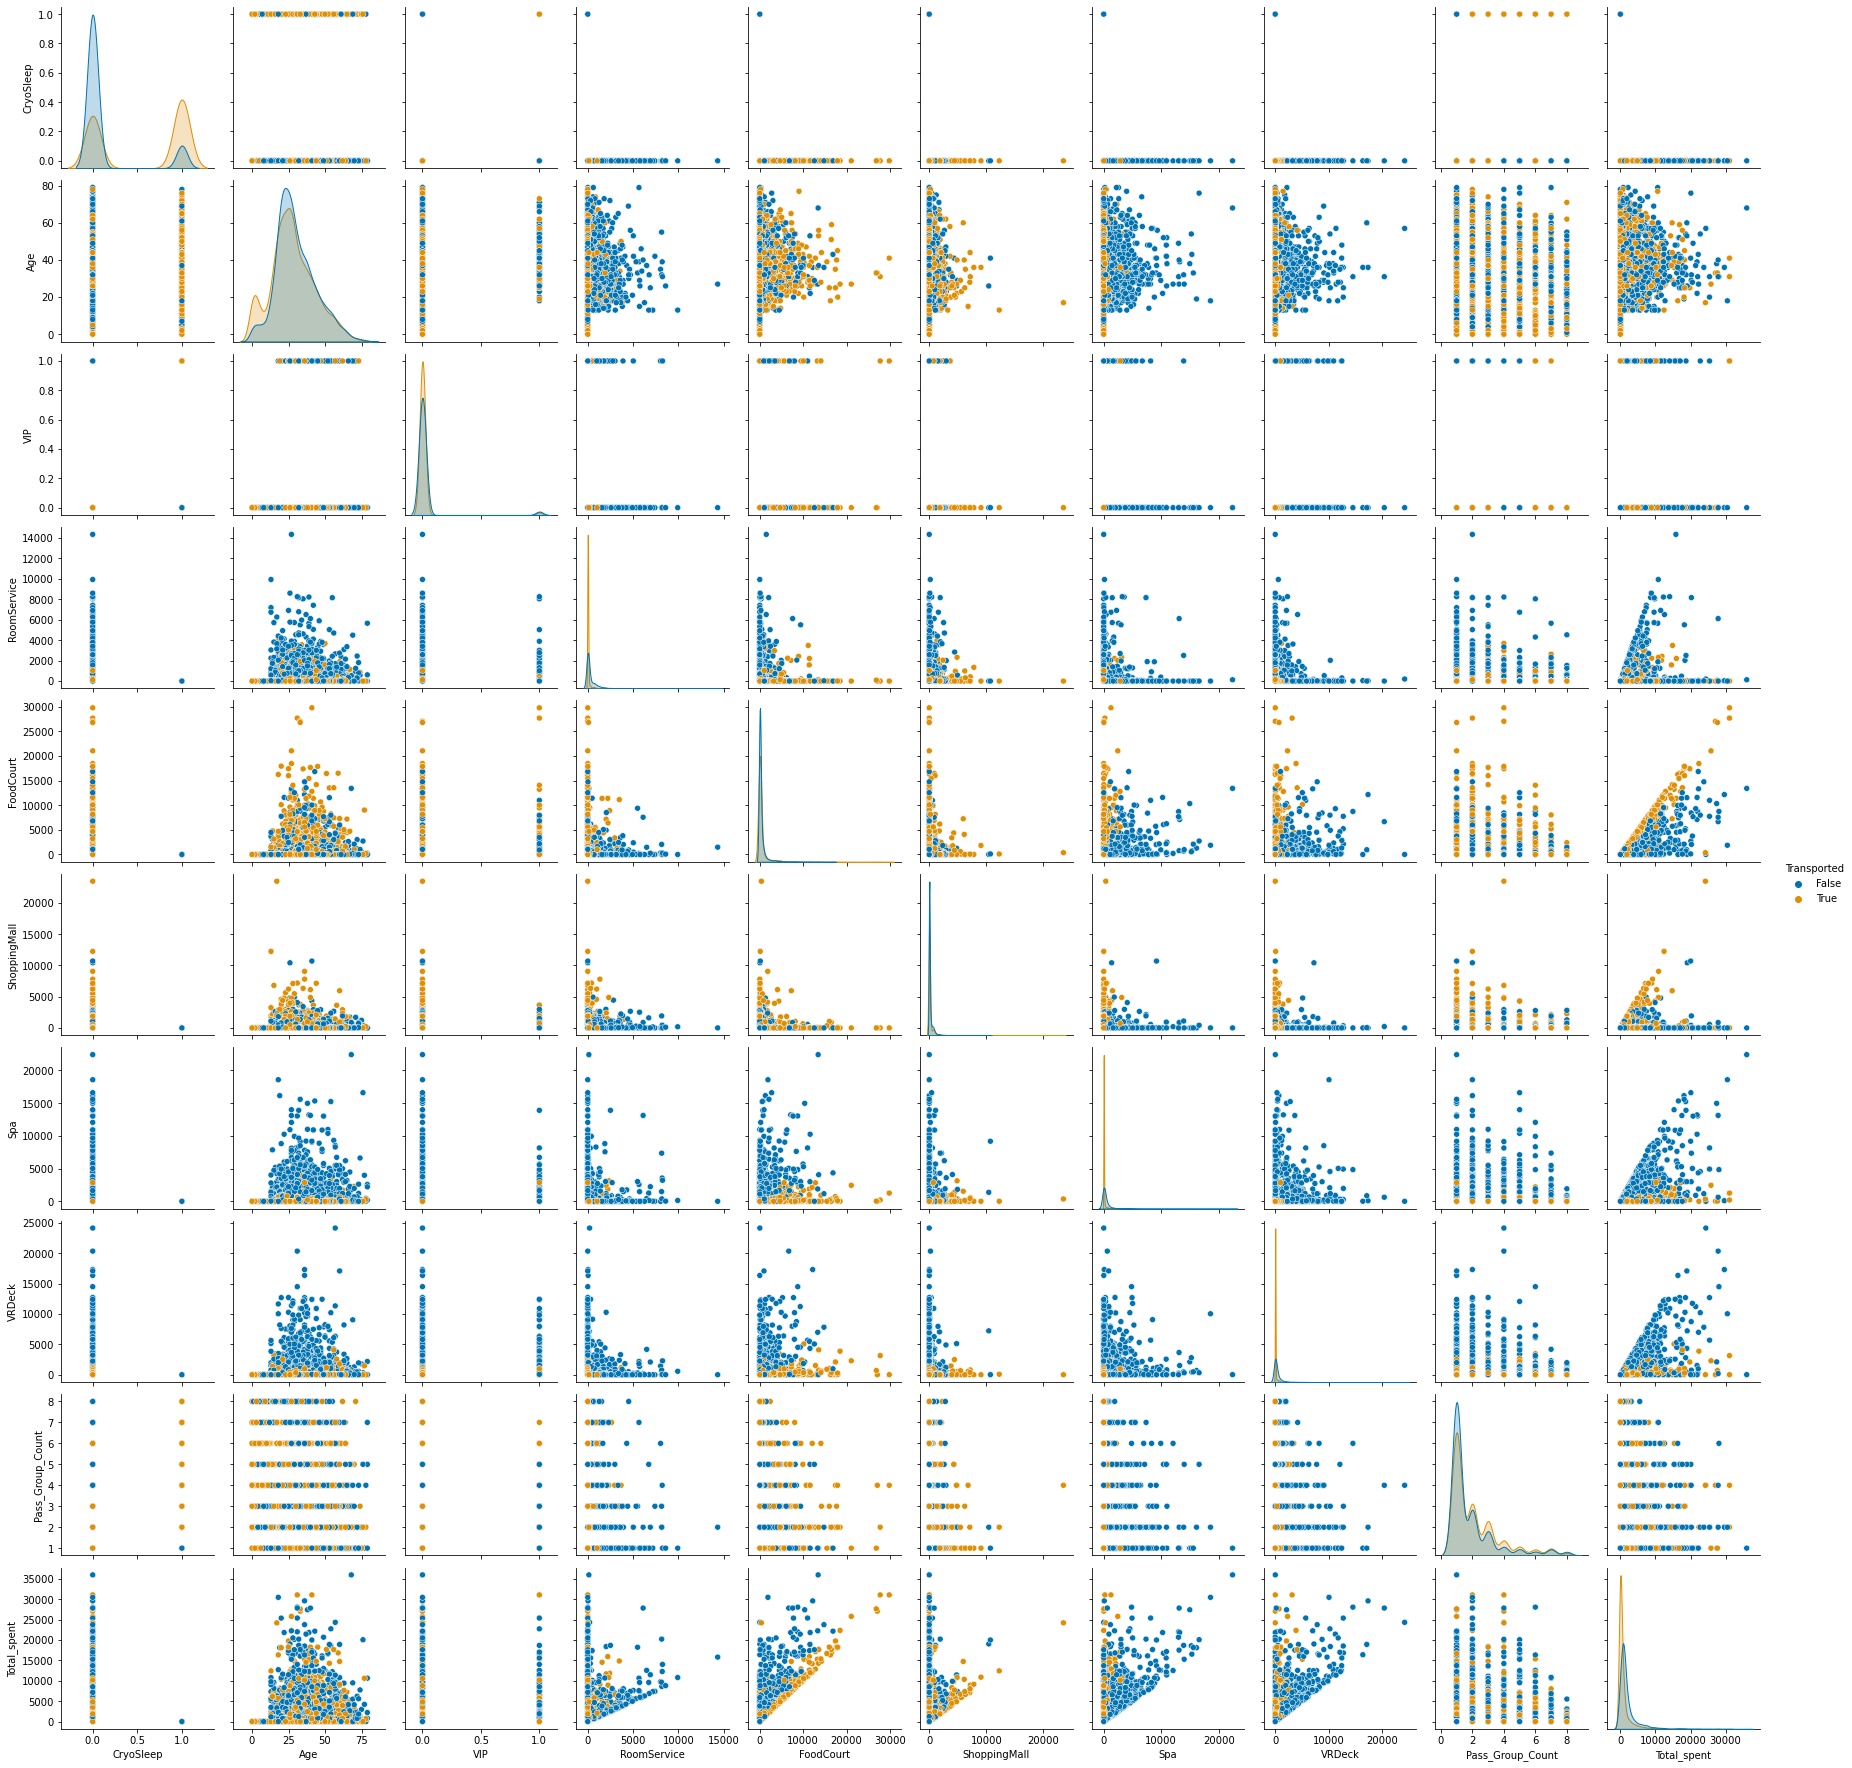

In [49]:
sns.pairplot(train_df, hue="Transported")

## Part 3: Preprocessing & Modelling

The dataset will be split into train & test.

The train set will then be used w/ cross_val so effectively the data will be split into train & test & valid sets.

Models to be tested:

Inıtial Testing:
* Decision Trees
* Random Forests
* AdaBoost
* Gradient Boosting

Secondary Testing:
* Logistic Regression
* Support Vector Machines
* K-Nearest Neighbor

As an initial step there will be no Feature Selection step as the inital models to be tested can also be used for this process. Using the features importances from these inital models & later some statistical tests, a final feature space can be determined, depending on model performances.


Also, the num. features are not to be scaled as all the models in initial testing can handle num. variables as they are. 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop("Transported", axis=1), train_df["Transported"], test_size=.3, stratify=train_df["Transported"])

In [52]:
onehotenc = OneHotEncoder(drop="if_binary", sparse=False)
#ssenc = StandardScaler()

cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Pass_Group_Count' , 'Total_spent']

# Encoding Categorical Variables:
X_train_cat = onehotenc.fit_transform(X_train[cat_cols])

# Getting Ready & Encoding Numerical Variables: (if necessary)
X_train_num = X_train[num_cols]
#X_train_num_std = ssenc.fit_transform(X_train_num)

# Final X_train datasets:
X_train_ready = np.concatenate([X_train_cat,X_train_num.values], axis=1)
#X_train_ready_std = np.concatenate([X_train_cat,X_train_num_std], axis=1)


In [53]:
# Repeating the same for X_test:
X_test_cat = onehotenc.transform(X_test[cat_cols])

X_test_num = X_test[num_cols]
#X_test_num_std = ssenc.transform(X_test_num)

X_test_ready = np.concatenate([X_test_cat,X_test_num.values], axis=1)
#X_test_ready_std = np.concatenate([X_test_cat,X_test_num_std], axis=1)

In [67]:
# Initiating Models:

dtc = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
logreg = LogisticRegression()


In [68]:
# 1- Logistic Regression:

scores_logreg = cross_val_score(logreg, X_train_ready, y_train,verbose=0)
scores_logreg.mean()

C:\Users\oguzk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\oguzk\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.7865242399342646

In [55]:
# 2- Decision Tree Classifier:

scores_dtc = cross_val_score(dtc, X_train_ready, y_train)
scores_dtc.mean()

0.7350862777321282

In [56]:
# 3- Random Forest Clasifier:
scores_rf = cross_val_score(dtc, X_train_ready, y_train)
scores_rf.mean()

0.7390304026294167

In [57]:
# 4- AdaBoost:

scores_ada = cross_val_score(ada, X_train_ready, y_train)
scores_ada.mean()

0.7863599013968776

In [59]:
# 5- Gradient Boosting Classifier:

scores_gbc = cross_val_score(gbc, X_train_ready, y_train)
scores_gbc.mean()

0.8016433853738703

The initial testing without any hyperparameter tuning or feature selection gives a result of .80 accuracy for GradientBoostingClassifier. We can either:

* try hyperparameter tuning for GBC
* continue with feature selection using stat. tests & feature importances & try different models

As there is a very low amount of features to begin with & not a lot of training data, it can be theorized that a GridSearchCV can increase the performance more efficiently in this case.

## Part 4: Grid Search & Hyperparameter Tuning

GBC gave the best inital accuracy score overall, and therefore selected as the base model.

The next step is hyperparameter tuning, and this can be done with GridSearch as the training data is not that large & won't be too time consuming.

In [72]:
param_dict = {
    "n_estimators" : [100, 500, 1000, 2500],
    "max_depth" : [3, 5, 7, 10],
    "max_features": ["auto", "sqrt", "log2", None],
    "ccp_alpha" : [0, 0.001, 0.05, 0.1]
}

clf = GridSearchCV(gbc, param_grid=param_dict)

In [73]:
clf.fit(X_train_ready, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'ccp_alpha': [0, 0.001, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [100, 500, 1000, 2500]})

In [74]:
clf.best_score_

0.8057518488085457

In [75]:
clf.best_params_

{'ccp_alpha': 0, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}

In [78]:
# Creating the "best" GBC with the Grid Search results:

gbc_best = GradientBoostingClassifier(max_depth= 5, max_features= 'auto', n_estimators= 100)

In [79]:
# Fitting the entire X_train dataset to get feature importances & final accuracy score:

gbc_best.fit(X_train_ready, y_train)
y_pred = gbc_best.predict(X_test_ready)

GradientBoostingClassifier(max_depth=5, max_features='auto')

In [83]:
# The hyperparameter tuned model accuracy:

accuracy_score(y_test, y_pred)

0.808282208588957

It is seen that the model accuracy did not increase significantly after hyperparameter tuning. This is not extremely unexpected due tp the low number of samples in training dataset & the characteristic of GBC, as it is known as a out of the box model that performs well without any tuning. 

I would expect a better improvement if the dataset was latger both in terms of samples & features.

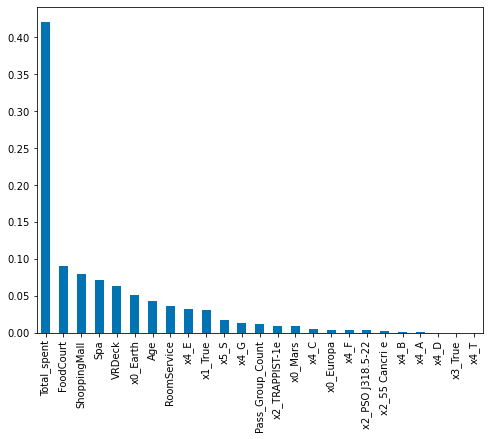

In [116]:
# Feature Importances according to GBC:

feat_names = list(onehotenc.get_feature_names()) + list(X_train_num.columns)
gbc_feat_imps = pd.Series(data = gbc_best.feature_importances_, index=feat_names)

plt.figure(figsize=(8, 6))
gbc_feat_imps.sort_values(ascending=False).plot.bar()
plt.show()

It can be seen that the features related to the money spent by the passengers give the most information about their eventual fate. This validates the initial findings in EDA part, as the the distributions showed Food_court, Shopping_mall and Spa spendings actually had some (alth. weak) correlation with the target variable.

## Part 5: Predicting the actual test dataset & upload to Kaggle

Now that the model is determined & we can predict the test.csv dataset & upload the predictions to Kaggle. To do this we can atually use the entire train dataset to fit the dataset. So the final datasets should be prepared.

### 5.1 - X_train_final & y_train_final

In [12]:
onehotenc = OneHotEncoder(drop="if_binary", sparse=False)

X_final = train_df.drop("Transported", axis=1)
y_final = train_df["Transported"]

cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Pass_Group_Count' , 'Total_spent']

X_final_cat = onehotenc.fit_transform(X_final[cat_cols])

X_final_ready = np.concatenate([X_final_cat,X_final[num_cols]], axis=1)


### 5.2 - X_pred_final

In [46]:
test_df = pd.read_csv("test.csv")
print(f"Test dataset shape: {test_df.shape}")

Test dataset shape: (4277, 13)


In [33]:
test_df.drop(["Name"], axis=1, inplace=True)

# CyroSleep & Money Spending

test_df[test_df.CryoSleep == True][["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].fillna(0,inplace=True)
test_df.loc[(test_df["RoomService"]==0) & (test_df["FoodCourt"]==0) & (test_df["ShoppingMall"]==0) & (test_df["Spa"]==0) & (test_df["VRDeck"]==0),"CryoSleep"].fillna(True,inplace=True)

test_obj_cols = test_df.select_dtypes("object").columns
test_num_cols = test_df.select_dtypes("number").columns

# Numerical Median fillna:
test_df.loc[:,test_num_cols] = test_df[test_num_cols].fillna(test_df[test_num_cols].median())

# Cabin Case: (as it will be feat. eng. later, will fill with each indiv most freq of deck & side feats:)
test_df.loc[:,"Cabin"] = test_df["Cabin"].fillna("F/001/S")

# Categorical fillna:
test_df.loc[:,:] = simp.transform(test_df)

# 1 - Passenger Group Person count:
pssngr_group_count_dict = test_df.PassengerId.str[:4].value_counts().to_dict()
test_df["Pass_Group_Count"] = test_df.PassengerId.str[:4].map(pssngr_group_count_dict)

# 2 -  Cabin Deck
test_df["Cabin_deck"] = test_df.Cabin.str[0] 

# 3 - Cabin Side
test_df["Cabin_side"] = test_df.Cabin.str[-1]

# 4 - Total Money Spent:
test_df["Total_spent"] = test_df["RoomService"] + test_df["FoodCourt"] + test_df["ShoppingMall"] + test_df["Spa"] + test_df["VRDeck"]

# Cabin & PassengerId cols can now be dropped:
test_df.drop(["PassengerId","Cabin"], axis=1, inplace=True)




In [36]:
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Pass_Group_Count' , 'Total_spent']

test_df_cat = onehotenc.fit_transform(test_df[cat_cols])

test_df_ready = np.concatenate([test_df_cat,test_df[num_cols]], axis=1)

test_df_ready.shape

(4277, 25)

### 5.3 - Test Dataset Prediction:

In [43]:
gbc_best.fit(X_final_ready, y_final)
final_preds = gbc_best.predict(test_df_ready)

GradientBoostingClassifier(max_depth=5, max_features='auto')

In [47]:
# Exporting final predictions:

test_df_csv = pd.Series(final_preds, test_df.PassengerId)
test_df_csv.to_csv("kaggle_subm.csv")

The Kaggle submission resulted in a final accuracy score of __0.80336__

This is above the initial target of 80% accuracy, so the results are although not amazing still satisfactory. 

Seeing that the best submission has an accuracy of "0.81388", this submission is not far off with only around - 1% accuracy performance. 

Therefore although there are many potential improvement areas to be explored, this project can be concluded with this model & prediction performance